In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = pd.read_csv('data/soup_aruodas_2021_10_16-1507.csv', decimal=',')
dataset = dataset[dataset['city'].isin(['Vilnius', 'Kaunas', 'Klaipėda', 'Palanga', 'Šiauliai', 'Panevėžys'])]

In [3]:
# cleaning data
cleanData = dataset.copy()
cleanData = cleanData.drop(['avg_heat_per_m', 'heating_type', 'building_type', 'floor', 'installation'], 1)
cleanData.dropna(inplace=True)

In [4]:
# separating features set from dependent variable
y = cleanData.iloc[:, -1].values
y = y.reshape(len(y),1)
X = cleanData.iloc[:, :-1]
# encoding the categorical data
X = pd.get_dummies(X, columns=['city']).values

In [5]:
# splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
# feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
y_train = sc_y.fit_transform(y_train)
y_test = sc_y.transform(y_test)

In [7]:
#checking each feature significance
import statsmodels.api as sm
X_train_sm = np.array(X_train, dtype=float)
X_train_sm = sm.add_constant(X_train_sm)
lm_1 = sm.OLS(y_train, X_train_sm).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.564
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     334.0
Date:                Sat, 27 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:56:53   Log-Likelihood:                -2080.7
No. Observations:                2073   AIC:                             4179.
Df Residuals:                    2064   BIC:                             4230.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.638e-17      0.015   3.88e-15      1.0

In [8]:
# defining ANN model
def ann_model():
    ann = tf.keras.models.Sequential()
    ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
    ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
    ann.add(tf.keras.layers.Dense(units=5, activation='relu'))
    ann.add(tf.keras.layers.Dense(units=1))
    ann.compile(optimizer = 'adam', loss = 'mean_squared_error')
    return ann

In [9]:
ann = ann_model()
history = ann.fit(X_train, y_train, batch_size = 32, epochs = 100, validation_data = (X_test, y_test), verbose = 0)

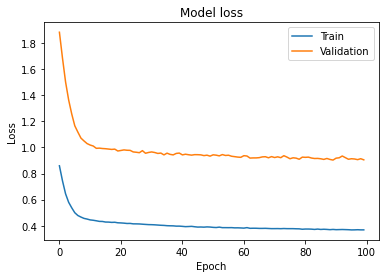

In [10]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [11]:
y_pred_train = sc_y.inverse_transform(ann.predict(X_train))
y_pred = sc_y.inverse_transform(ann.predict(X_test))
#np.set_printoptions(precision=2)
#print(np.concatenate((y_pred.reshape(len(y_pred),1), sc_y.inverse_transform(y_test).reshape(len(y_test),1)),1))

In [12]:
from sklearn.metrics import r2_score
print(r2_score(sc_y.inverse_transform(y_train), y_pred_train))
print(r2_score(sc_y.inverse_transform(y_test), y_pred))

0.636070396093664
0.6093802463515823
